# Lesson 28: TensorFlow/Keras classification activity

## Notebook set up
### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers

## 1. Data preparation

### 1.1. Load occupancy data

In [2]:
occupancy_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/occupancy_data.csv')
occupancy_df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
occupancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
label = 'Occupancy'
features = ['Temperature','Humidity','Light','CO2','HumidityRatio']

### 1.2. Train test split

In [5]:
training_df, testing_df = train_test_split(occupancy_df, random_state=315)

### 1.3. Standard scale

#### Features

In [6]:
feature_scaler = StandardScaler()
feature_scaler.fit(training_df[features])

training_df[features] = feature_scaler.transform(training_df[features])
testing_df[features] = feature_scaler.transform(testing_df[features])

## 2. Logistic regression baseline

### 2.1. Fit

In [7]:
logistic_model = LogisticRegression(n_jobs=-1, random_state=315)
fit_result = logistic_model.fit(training_df[features], training_df[label])

### 2.2. Test set evaluation

In [8]:
logistic_predictions = logistic_model.predict(testing_df[features])
logistic_accuracy = accuracy_score(testing_df[label], logistic_predictions)
print(f'Logistic regression accuracy on test set: {logistic_accuracy:.4f}')

Logistic regression accuracy on test set: 0.9907


## 3. Keras Sequential API model

The Sequential API is the simplest way to build a neural network in Keras. It allows you to create models layer-by-layer in a linear stack.

### 3.1. Build model

In [9]:
tf.random.set_seed(315)

sequential_model = keras.Sequential([
    layers.Input(shape=(5,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

sequential_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2. Compute class weights

In [10]:
# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_df[label]),
    y=training_df[label]
)

class_weight_dict = dict(enumerate(class_weights))
print(f'Class weights: {class_weight_dict}')

Class weights: {0: 0.6505231184610193, 1: 2.1608744394618835}


### 3.3. Train model

In [11]:
sequential_history = sequential_model.fit(
    training_df[features],
    training_df[label],
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    #class_weight=class_weight_dict,
    verbose=1
)

print('Training complete.')
print(f'Final training loss: {sequential_history.history["loss"][-1]:.4f}')
print(f'Final validation loss: {sequential_history.history["val_loss"][-1]:.4f}')
print(f'Final training accuracy: {sequential_history.history["accuracy"][-1]:.4f}')
print(f'Final validation accuracy: {sequential_history.history["val_accuracy"][-1]:.4f}')

Epoch 1/100


I0000 00:00:1769127134.086152   45770 service.cc:145] XLA service 0x7e75398cb210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769127134.086188   45770 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769127134.086196   45770 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
I0000 00:00:1769127134.212774   45770 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1542/1542 [==============================] - 30s 6ms/step - loss: 0.6395 - accuracy: 0.6712 - val_loss: 0.5369 - val_accuracy: 0.9134
Epoch 2/100
1542/1542 [==============================] - 10s 6ms/step - loss: 0.4306 - accuracy: 0.9267 - val_loss: 0.3314 - val_accuracy: 0.9374
Epoch 3/100
1542/1542 [==============================] - 9s 6ms/step - loss: 0.2615 - accuracy: 0.9541 - val_loss: 0.1978 - val_accuracy: 0.9617
Epoch 4/100
1542/1542 [==============================] - 10s 6ms/step - loss: 0.1597 - accuracy: 0.9765 - val_loss: 0.1218 - val_accuracy: 0.9841
Epoch 5/100
1542/1542 [==============================] - 10s 6ms/step - loss: 0.1028 - accuracy: 0.9846 - val_loss: 0.0798 - val_accuracy: 0.9899
Epoch 6/100
1542/1542 [==============================] - 11s 7ms/step - loss: 0.0740 - accuracy: 0.9869 - val_loss: 0.0596 - val_accuracy: 0.9896
Epoch 7/100
1542/1542 [==============================] - 11s 7ms/step - loss: 0.0609 - accuracy: 0.9874 - val_loss: 0.0499 - val_accuracy

### 3.4. Learning curves

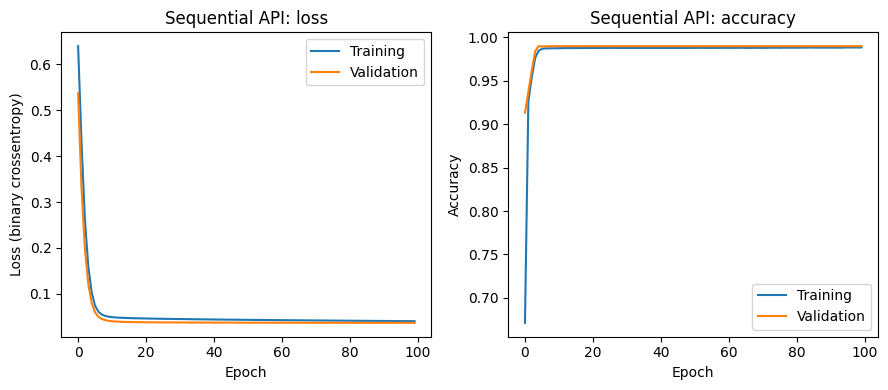

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].set_title('Sequential API: loss')
axes[0].plot(sequential_history.history['loss'], label='Training')
axes[0].plot(sequential_history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (binary crossentropy)')
axes[0].legend(loc='best')

axes[1].set_title('Sequential API: accuracy')
axes[1].plot(sequential_history.history['accuracy'], label='Training')
axes[1].plot(sequential_history.history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 3.5. Test set evaluation

In [13]:
sequential_probs = sequential_model.predict(testing_df[features], verbose=0).flatten()
sequential_predictions = (sequential_probs >= 0.5).astype(int)
sequential_accuracy = accuracy_score(testing_df[label], sequential_predictions)

print(f'Sequential API model accuracy on test set: {sequential_accuracy:.4f}')

Sequential API model accuracy on test set: 0.9911


### 3.6. Performance analysis

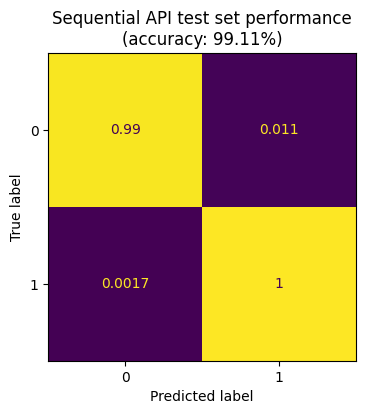

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.set_title(f'Sequential API test set performance\n(accuracy: {sequential_accuracy:.2%})')

disp = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    sequential_predictions,
    normalize='true',
    ax=ax,
    colorbar=False
)

## 4. Model comparison

In [15]:
print(f'Logistic regression accuracy on test set: {logistic_accuracy:.4f}')
print(f'Sequential API model accuracy on test set: {sequential_accuracy:.4f}')

Logistic regression accuracy on test set: 0.9907
Sequential API model accuracy on test set: 0.9911


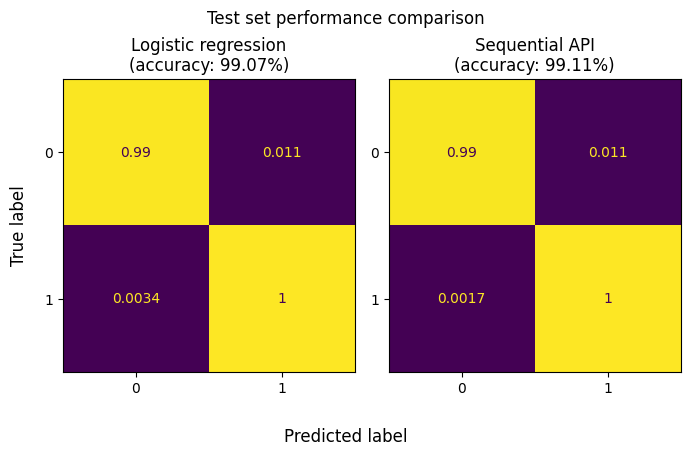

In [16]:
# Compare confusion matrices for baseline and trained model
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4.5))

fig.suptitle('Test set performance comparison')
fig.supxlabel('Predicted label')
fig.supylabel('True label')

# Confusion matrix for logistic regression
axes[0].set_title(f'Logistic regression\n(accuracy: {logistic_accuracy:.2%})')

disp_logistic = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    logistic_predictions,
    normalize='true',
    ax=axes[0],
    colorbar=False
)

axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Confusion matrix for sequential model
axes[1].set_title(f'Sequential API\n(accuracy: {sequential_accuracy:.2%})')

disp_sequential = ConfusionMatrixDisplay.from_predictions(
    testing_df[label],
    sequential_predictions,
    normalize='true',
    ax=axes[1],
    colorbar=False
)

axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()